# Imports

In [7]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import mlflow
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, roc_auc_score, balanced_accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors
from xgboost import XGBClassifier
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn import pipeline
from lime import lime_tabular

In [8]:
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [9]:
train = pd.read_csv("train_8.csv", sep = ",", low_memory=False)
train.shape

(307511, 666)

In [10]:
target = train['TARGET']
train.drop(columns = ['TARGET', 'SK_ID_CURR'], inplace = True)
features_names = list(train.columns)

In [11]:
test = pd.read_csv("test_8.csv", sep = ",", low_memory=False)
test.shape

(48744, 665)

In [12]:
X = train.values
y = target
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size = 0.1, random_state = 1, stratify = y)

In [13]:
def my_cost (target, predictions):
    """
    Evaluates the predictions of a model with a score that penalizes false positives 10 times more than false negatives
    
    Parameters
    ------
    predictions (array):
        the predictions made by your model
    target (Series):
        the real values
        
    Return
    ------
    A score that punishes 10 times more the false positives than the false negatives
    """
    #initialize score
    score = 0
    
    #calculate the penalties
    targeted = target.reset_index(drop=True)
    for i in targeted.index:
        if predictions[i] == 0 and targeted[i] == 1:
            score += 10
        elif predictions[i] == 1 and targeted[i] == 0:
            score += 1
    
    #normalizing
    score = score / len(predictions)
    
    return score

# Pour les validations croisées
cost_scorer  = make_scorer(my_cost, greater_is_better=False)

# Dummy : 0 par défaut

In [14]:
mlflow.start_run(run_name = "Baseline Dummy")

dum = DummyClassifier(strategy = 'constant', constant = 0)
dum.fit(X_train, y_train)
predictions_dummy = dum.predict(X_val)
    
score_dummy = my_cost(y_val, predictions_dummy)
print("Score de notre Baseline : ", score_dummy)

mlflow.log_param("strategy", 'constant')
mlflow.log_param("constant", 0)

Score de notre Baseline :  0.8074271592091571


0

In [15]:
accuracy_dummy = accuracy_score(y_val, predictions_dummy)
accuracy_dummy

0.9192572840790842

In [16]:
roc_auc_dummy = roc_auc_score(y_val, predictions_dummy)
roc_auc_dummy

0.5

In [17]:
def get_scores(model, X_test, y_val):
    """
    Gets our custom score, accuracy, and roc auc score for our model.
    """
    # We make a prediction
    y_pred = model.predict(X_test)
    
    # We get our scores
    score_model = my_cost(y_val, y_pred)
    accuracy_model = accuracy_score(y_val, y_pred)
    roc_auc_model = roc_auc_score(y_val, y_pred)
    
    # Then we get it as a dictionnary
    new_row = {'Notre score': score_model,
             'accuracy' : accuracy_model,
              'ROC AUC' : roc_auc_model
             }
    
    # For MLFlow
    mlflow.log_metric("our score", score_model)
    mlflow.log_metric("accuracy", accuracy_model)
    mlflow.log_metric("roc auc", roc_auc_model)
    
    return new_row

In [18]:
scores = pd.DataFrame(columns = ["Notre score","accuracy","ROC AUC"])

In [19]:
scores.loc["Dummy"] = get_scores(dum, X_val, y_val)
mlflow.end_run()
scores

,Notre score,accuracy,ROC AUC
Dummy,0.807427,0.919257,0.5


# Premiers tests : sans gérer le déséquilibre de classe

## Régression logistique

In [20]:
si = SimpleImputer(strategy = 'median')
mms = MinMaxScaler()
pipe =  Pipeline([('imputer', si), ('scaler', mms)])

pipe.fit(X_train)
X_scaled = pipe.transform(X_train)
X_val_scaled = pipe.transform(X_val)

In [21]:
'''
params = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-2, 2, 5)
}
'''

params = {'penalty' : ['l2'],
         'C' : [10]}

# On effectue la validation croisée
lr = LogisticRegression(max_iter = 2000)
grid = GridSearchCV(lr, params, scoring = cost_scorer)
grid.fit(X_scaled, y_train)
results = pd.DataFrame(grid.cv_results_)
results = results.sort_values('rank_test_score').reset_index(drop = True)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,25.332417,3.570482,0.157787,0.018423,10,l2,"{'C': 10, 'penalty': 'l2'}",-0.784994,-0.784344,-0.788607,-0.785066,-0.785261,-0.785655,0.001508,1


In [22]:
C = grid.best_params_["C"]

mlflow.start_run(run_name = "Logistic Regression")

lr = LogisticRegression(penalty = 'l2', C = C, max_iter = 10000)
lr.fit(X_scaled, y_train)

mlflow.log_param('penalty', 'l2')
mlflow.log_param('C', C)
mlflow.log_param('max_iter', 10000)

scores.loc["LogisticRegression"] = get_scores(lr, X_val_scaled, y_val)
mlflow.end_run()
scores

,Notre score,accuracy,ROC AUC
Dummy,0.807427,0.919257,0.500000
LogisticRegression,0.782746,0.919648,0.515458


In [23]:
pd.DataFrame(lr.predict(X_val_scaled)).value_counts()

0    30598
1      154
Name: count, dtype: int64

## Foret aléatoire

In [24]:
'''
params = {'n_estimators' : [50, 100, 150, 200, 300, 400, 500],
         'class_weight' : ['None','balanced']}
'''

params = {'n_estimators' : [50],
         'class_weight' : ['balanced']}

rf = RandomForestClassifier(n_jobs = -1)
grid = GridSearchCV(rf, params, scoring = cost_scorer)
grid.fit(X_scaled, y_train)
results = pd.DataFrame(grid.cv_results_)
results = results.sort_values('rank_test_score').reset_index(drop = True)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,14.868999,0.224629,0.35313,0.011841,balanced,50,"{'class_weight': 'balanced', 'n_estimators': 50}",-0.806077,-0.806222,-0.806529,-0.806059,-0.806887,-0.806355,0.000315,1


In [25]:
n_estimators = grid.best_params_["n_estimators"]
rf = RandomForestClassifier(n_estimators = n_estimators, class_weight = 'balanced', n_jobs = -1)
rf.fit(X_scaled, y_train)

mlflow.start_run(run_name = "Randomforest")
mlflow.log_param("n_estimators", n_estimators)
scores.loc["RandomForest"] = get_scores(rf, X_val_scaled, y_val)
mlflow.end_run()
scores

,Notre score,accuracy,ROC AUC
Dummy,0.807427,0.919257,0.500000
LogisticRegression,0.782746,0.919648,0.515458
RandomForest,0.805996,0.919225,0.500901


In [26]:
pd.DataFrame(rf.predict(X_val_scaled)).value_counts()

0    30741
1       11
Name: count, dtype: int64

## XGBoost

In [27]:
'''
params = {'n_estimators' : [100, 200],
          'max_depth' : [3, 7],
          'learning_rate' : [0.01, 0.1],
           'min_child_weight' : [0.5, 1, 2],
           'subsample' : [0.5,1]
         }
'''

params = {'n_estimators' : [200],
          'max_depth' : [7],
          'learning_rate' : [0.1],
           'min_child_weight' : [0.5],
           'subsample' : [0.5]
         }

xgbr = XGBClassifier(n_jobs = -1)
grid = GridSearchCV(xgbr, params, scoring = cost_scorer)
grid.fit(X_scaled, y_train)
results = pd.DataFrame(grid.cv_results_)
results = results.sort_values('rank_test_score').reset_index(drop = True)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,19.414832,0.551763,0.284404,0.014512,0.1,7,0.5,200,0.5,"{'learning_rate': 0.1, 'max_depth': 7, 'min_ch...",-0.7685,-0.766838,-0.769295,-0.766476,-0.767448,-0.767711,0.001048,1


In [28]:
learning_rate = grid.best_params_["learning_rate"]
xgbc = XGBClassifier(learning_rate = learning_rate, n_jobs = -1)
xgbc.fit(X_scaled, y_train)

#mlflow.start_run(run_name = "xgboost imputé")
mlflow.log_param("learning_rate", learning_rate)
scores.loc["Xgboost imputé"] = get_scores(xgbc, X_val_scaled, y_val)
mlflow.end_run()
scores

,Notre score,accuracy,ROC AUC
Dummy,0.807427,0.919257,0.500000
LogisticRegression,0.782746,0.919648,0.515458
RandomForest,0.805996,0.919225,0.500901
Xgboost imputé,0.783039,0.919940,0.515250


In [29]:
pd.DataFrame(xgbc.predict(X_val_scaled)).value_counts()

0    30611
1      141
Name: count, dtype: int64

In [30]:
#La même chose, mais sans imputer
mms.fit(X_train)
X_train_only_scaled = mms.transform(X_train)
X_val_only_scaled = mms.transform(X_val)

learning_rate = grid.best_params_["learning_rate"]
xgbc = XGBClassifier(learning_rate = learning_rate, n_jobs = -1)
xgbc.fit(X_train_only_scaled, y_train)

mlflow.start_run(run_name = "xgboost non imputé")
mlflow.log_param("learning_rate", learning_rate)
scores.loc["Xgboost non imputé"] = get_scores(xgbc, X_val_only_scaled, y_val)
mlflow.end_run()
scores

,Notre score,accuracy,ROC AUC
Dummy,0.807427,0.919257,0.500000
LogisticRegression,0.782746,0.919648,0.515458
RandomForest,0.805996,0.919225,0.500901
Xgboost imputé,0.783039,0.919940,0.515250
Xgboost non imputé,0.781770,0.920038,0.516037


In [31]:
pd.DataFrame(xgbc.predict(X_val_only_scaled)).value_counts()

0    30606
1      146
Name: count, dtype: int64

# Gestion du déséquilibre des classes

## Random Undersampling

In [32]:
under = RandomUnderSampler(random_state = 50, sampling_strategy = 1)
X_even, y_even = under.fit_resample(X_train_only_scaled, y_train)

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
`BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
`BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.


In [33]:
'''
params = {'n_estimators' : [100, 200],
          'max_depth' : [3, 7],
          'learning_rate' : [0.01, 0.1],
          'min_child_weight' : [0.5, 1]
         }
'''

params = {'n_estimators' : [200],
          'max_depth' : [3],
          'learning_rate' : [0.1],
          'min_child_weight' : [1]
         }

xgbr = XGBClassifier(n_jobs = -1)
grid = GridSearchCV(xgbr, params, scoring = cost_scorer)
grid.fit(X_even, y_even)
results = pd.DataFrame(grid.cv_results_)
results = results.sort_values('rank_test_score').reset_index(drop = True)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.791703,0.213953,0.053688,0.002511,0.1,3,1,200,"{'learning_rate': 0.1, 'max_depth': 3, 'min_ch...",-1.586774,-1.630301,-1.631084,-1.640931,-1.56457,-1.610732,0.029712,1


In [34]:
learning_rate = grid.best_params_["learning_rate"]
n_estimators = grid.best_params_["n_estimators"]
max_depth = grid.best_params_["max_depth"]
min_child_weight = grid.best_params_["min_child_weight"]
xgbc = XGBClassifier(learning_rate = learning_rate, n_estimators = n_estimators, max_depth = max_depth, min_child_weight = min_child_weight, n_jobs = -1)
xgbc.fit(X_even, y_even)

mlflow.start_run(run_name = "xgboost with random undersampling")
mlflow.log_param("learning_rate", learning_rate)
mlflow.log_param("n_estimators", n_estimators)
mlflow.log_param("max_depth", max_depth)
mlflow.log_param("min_child_weight", min_child_weight)
scores.loc["Xgboost with random undersampling"] = get_scores(xgbc, X_val_only_scaled, y_val)
mlflow.end_run()
scores

,Notre score,accuracy,ROC AUC
Dummy,0.807427,0.919257,0.500000
LogisticRegression,0.782746,0.919648,0.515458
RandomForest,0.805996,0.919225,0.500901
Xgboost imputé,0.783039,0.919940,0.515250
Xgboost non imputé,0.781770,0.920038,0.516037
Xgboost with random undersampling,0.510698,0.710263,0.703727


## SMOTE + Random Undersampling

In [35]:
over = SMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=1)
steps = [('o', over), ('u', under)]
# pipeline de imblearn, non sklearn
pipe = pipeline.Pipeline(steps=steps)

X_smoted, y_smoted = pipe.fit_resample(X_scaled, y_train)
X_smoted.shape

`BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
`BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
`BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.


(101766, 664)

In [36]:
'''
params = {'n_estimators' : [100, 200],
          'max_depth' : [3, 7],
          'learning_rate' : [0.01, 0.1],
          'min_child_weight' : [0.5, 1]
         }
'''

params = {'n_estimators' : [200],
          'max_depth' : [7],
          'learning_rate' : [0.1],
          'min_child_weight' : [1]
         }

xgbr = XGBClassifier(n_jobs = -1)
grid = GridSearchCV(xgbr, params, scoring = cost_scorer)
grid.fit(X_smoted, y_smoted)

results = pd.DataFrame(grid.cv_results_)
results = results.sort_values('rank_test_score').reset_index(drop = True)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,14.295252,0.633344,0.120453,0.003779,0.1,7,1,200,"{'learning_rate': 0.1, 'max_depth': 7, 'min_ch...",-3.461285,-3.536186,-0.55805,-0.084017,-0.085049,-1.544918,1.604803,1


In [37]:
learning_rate = grid.best_params_["learning_rate"]
n_estimators = grid.best_params_["n_estimators"]
max_depth = grid.best_params_["max_depth"]
min_child_weight = grid.best_params_["min_child_weight"]
xgbc = XGBClassifier(learning_rate = learning_rate,
                     n_estimators = n_estimators,
                     max_depth = max_depth,
                     min_child_weight = min_child_weight,
                     n_jobs = -1)
xgbc.fit(X_smoted, y_smoted)

mlflow.start_run(run_name = "xgboost with smote and undersampling")
mlflow.log_param("learning_rate", learning_rate)
mlflow.log_param("max_depth", max_depth)
scores.loc["Xgboost with smote and undersampling"] = get_scores(xgbc, X_val_only_scaled, y_val)
mlflow.end_run()
scores

,Notre score,accuracy,ROC AUC
Dummy,0.807427,0.919257,0.500000
LogisticRegression,0.782746,0.919648,0.515458
RandomForest,0.805996,0.919225,0.500901
Xgboost imputé,0.783039,0.919940,0.515250
Xgboost non imputé,0.781770,0.920038,0.516037
Xgboost with random undersampling,0.510698,0.710263,0.703727
Xgboost with smote and undersampling,0.699011,0.719205,0.584789


## LightGBM

In [38]:
'''
params = {'n_estimators' : [100, 200, 500, 1000],
          'learning_rate' : [0.01, 0.05, 0.1],
          'max_depth' : [3, 5, 7],
          'reg_alpha' : [0, 0.1],
          'reg_lambda' : [0, 0.1]
         }
'''

params = {'n_estimators' : [1000],
          'learning_rate' : [0.05],
          'max_depth' : [3],
          'reg_alpha' : [0],
          'reg_lambda' : [0]
         }

lgbm = lgb.LGBMClassifier(objective = 'binary',
                          n_jobs = -1,
                          random_state = 50)

grid = GridSearchCV(lgbm, params, scoring = cost_scorer)
grid.fit(X_even, y_even)

results = pd.DataFrame(grid.cv_results_)
results = results.sort_values('rank_test_score').reset_index(drop = True)
results

[LightGBM] [Info] Number of positive: 17874, number of negative: 17873
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43585
[LightGBM] [Info] Number of data points in the train set: 35747, number of used features: 643
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500014 -> initscore=0.000056
[LightGBM] [Info] Start training from score 0.000056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

X does not have valid feature names, but LGBMClassifier was fitted with feature names


[LightGBM] [Info] Number of positive: 17874, number of negative: 17873
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43651
[LightGBM] [Info] Number of data points in the train set: 35747, number of used features: 643
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500014 -> initscore=0.000056
[LightGBM] [Info] Start training from score 0.000056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

X does not have valid feature names, but LGBMClassifier was fitted with feature names


[LightGBM] [Info] Number of positive: 17873, number of negative: 17874
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43641
[LightGBM] [Info] Number of data points in the train set: 35747, number of used features: 643
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499986 -> initscore=-0.000056
[LightGBM] [Info] Start training from score -0.000056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

X does not have valid feature names, but LGBMClassifier was fitted with feature names


[LightGBM] [Info] Number of positive: 17873, number of negative: 17874
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43620
[LightGBM] [Info] Number of data points in the train set: 35747, number of used features: 642
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499986 -> initscore=-0.000056
[LightGBM] [Info] Start training from score -0.000056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

X does not have valid feature names, but LGBMClassifier was fitted with feature names


[LightGBM] [Info] Number of positive: 17874, number of negative: 17874
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43554
[LightGBM] [Info] Number of data points in the train set: 35748, number of used features: 643
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

X does not have valid feature names, but LGBMClassifier was fitted with feature names


[LightGBM] [Info] Number of positive: 22342, number of negative: 22342
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.116805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44936
[LightGBM] [Info] Number of data points in the train set: 44684, number of used features: 646
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,param_reg_alpha,param_reg_lambda,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,4.575854,0.124073,0.092495,0.00237,0.05,3,1000,0,0,"{'learning_rate': 0.05, 'max_depth': 3, 'n_est...",-1.556563,-1.599194,-1.619223,-1.586998,-1.549799,-1.582355,0.026037,1


In [39]:
learning_rate = grid.best_params_["learning_rate"]
n_estimators = grid.best_params_["n_estimators"]
reg_alpha = grid.best_params_["reg_alpha"]
reg_lambda = grid.best_params_["reg_lambda"]
max_depth = grid.best_params_["max_depth"]

lgbm = lgb.LGBMClassifier(objective = 'binary',
                      learning_rate = learning_rate,
                      n_estimators = n_estimators,
                      max_depth = max_depth,
                      reg_alpha = reg_alpha,
                      reg_lambda = reg_lambda,
                      n_jobs = -1,
                     random_state = 50)
lgbm.fit(X_even, y_even)

mlflow.start_run(run_name = "LightGBM with even classes")
mlflow.log_param("learning_rate", learning_rate)
mlflow.log_param("n_estimators", n_estimators)
mlflow.log_param("reg_alpha", reg_alpha)
mlflow.log_param("reg_lambda", reg_lambda)
mlflow.log_param("max_depth", max_depth)
scores.loc["LightGBM with even classes"] = get_scores(lgbm, X_val_only_scaled, y_val)
mlflow.lightgbm.log_model(lgbm, "model")
mlflow.end_run()
run_id = mlflow.last_active_run().info.run_id
scores

[LightGBM] [Info] Number of positive: 22342, number of negative: 22342
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44936
[LightGBM] [Info] Number of data points in the train set: 44684, number of used features: 646
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

X does not have valid feature names, but LGBMClassifier was fitted with feature names
2025/11/28 11:24:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/28 11:24:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


,Notre score,accuracy,ROC AUC
Dummy,0.807427,0.919257,0.500000
LogisticRegression,0.782746,0.919648,0.515458
RandomForest,0.805996,0.919225,0.500901
Xgboost imputé,0.783039,0.919940,0.515250
Xgboost non imputé,0.781770,0.920038,0.516037
Xgboost with random undersampling,0.510698,0.710263,0.703727
Xgboost with smote and undersampling,0.699011,0.719205,0.584789
LightGBM with even classes,0.498764,0.714880,0.710831


# Feature importance globale

In [40]:
# Pour avoir une liste et non un Series
feature_importance = np.zeros(train.shape[1])

# On utilise directement l'attribut du LightGBM
feature_importance += lgbm.feature_importances_

feature_importance = pd.DataFrame({'feature': features_names, 'importance': feature_importance}).sort_values('importance', ascending = False)

feature_importance.head()

,feature,importance
25,EXT_SOURCE_1,219.0
660,CREDIT_TERM,214.0
27,EXT_SOURCE_3,189.0
26,EXT_SOURCE_2,175.0
8,DAYS_BIRTH,132.0


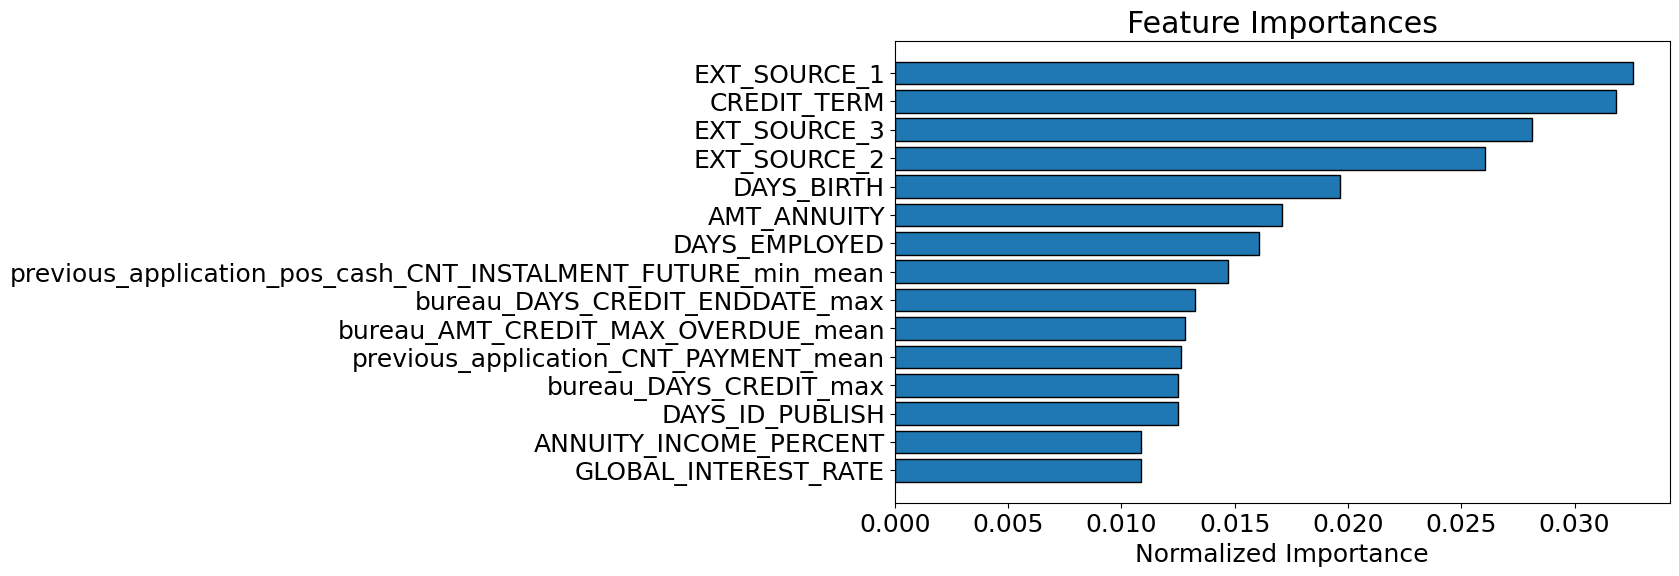

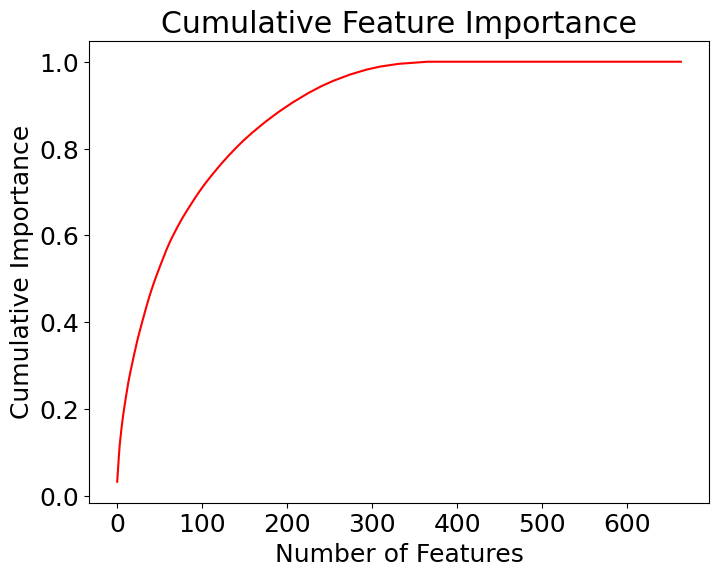

315 features required for 0.99 of cumulative importance


In [41]:
def plot_feature_importances(df, threshold = 0.9):
    """
    Trace les 15 features les plus importantes, ainsi que la courbe cumulative de feature importance.
    Affiche le nombre de features nécessaires pour atteindre le seuil demandé. (0.9 si non précisé)
    
    Parameters
    --------
    df : dataframe
        Dataframe de feature importances. Les colonnes doivent être 'feature' et 'importance'
    threshold : float, default = 0.9
        Seuil d'affichage demandé
        
    Return
    --------
    df : dataframe
        Dataframe trié par feature importances avec une colonne normalisée (sums to 1)
        et une colonne d'importance cumulée
    
    """
    
    plt.rcParams['font.size'] = 18
    
    # Range les features par ordre d'importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalisation de la feature importance (pour créer les valeurs nécessaires au cumulatif)
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Pour le diagramme en bâtons horizontal de feature importance
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Il faut inverser l'index pour avoir le meilleur en haut
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Légende
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Pour la feature importance cumulée
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

df = plot_feature_importances(feature_importance, threshold = 0.99)

In [42]:
zero_importance = list(feature_importance[feature_importance['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_importance))
feature_importance.tail(10)

There are 299 features with 0.0 importance


,feature,importance
208,bureau_CNT_CREDIT_PROLONG_min,0.0
70,NAME_TYPE_SUITE_Group of people,0.0
76,NAME_INCOME_TYPE_Commercial associate,0.0
75,NAME_INCOME_TYPE_Businessman,0.0
74,NAME_TYPE_SUITE_Unaccompanied,0.0
22,REG_REGION_NOT_WORK_REGION,0.0
72,NAME_TYPE_SUITE_Other_B,0.0
219,bureau_AMT_CREDIT_SUM_OVERDUE_min,0.0
71,NAME_TYPE_SUITE_Other_A,0.0
332,previous_application_NFLAG_INSURED_ON_APPROVAL...,0.0


In [43]:
small_train = train.drop(columns = zero_importance)
small_train.shape

(307511, 365)

In [44]:
# On réeffectue les transformations 
small_features_names = list(small_train.columns)

X = small_train.values
X_s_train, X_s_val, y_s_train, y_s_val = train_test_split(X,y,test_size = 0.1, random_state = 1, stratify = y)

# scaling avec imputation pour smote
si = SimpleImputer(strategy = 'median')
mms = MinMaxScaler()
prepropipe =  Pipeline([('imputer', si), ('scaler', mms)])

prepropipe.fit(X_s_train)
X_s_scaled = prepropipe.transform(X_s_train)
X_s_val_scaled = prepropipe.transform(X_s_val)

In [45]:
model = pipeline.Pipeline([
        ('smote', SMOTE(random_state = 50)),
        ('under', RandomUnderSampler(random_state = 50)),
        ('classification', lgb.LGBMClassifier(objective = 'binary',
                                              n_jobs = -1,
                                              random_state = 50))
    ])

param_grid = {
        "classification__n_estimators": [1000],
        "classification__learning_rate": [0.05],
        "classification__reg_alpha" : [0],
        "classification__reg_lambda" : [0],
        "classification__max_depth" : [3]
    }    


grid = GridSearchCV(model, param_grid = param_grid, scoring = cost_scorer, n_jobs = -1)
grid.fit(X_s_scaled, y_s_train)

results = pd.DataFrame(grid.cv_results_)
results = results.sort_values('rank_test_score').reset_index(drop = True)
results

`BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
`BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
`BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.


[LightGBM] [Info] Number of positive: 254417, number of negative: 254417
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.757482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 91608
[LightGBM] [Info] Number of data points in the train set: 508834, number of used features: 365
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classification__learning_rate,param_classification__max_depth,param_classification__n_estimators,param_classification__reg_alpha,param_classification__reg_lambda,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,183.876563,2.644911,1.014175,0.242817,0.05,3,1000,0,0,"{'classification__learning_rate': 0.05, 'class...",-0.780098,-0.781489,-0.785301,-0.781092,-0.78004,-0.781604,0.001932,1


In [46]:
n_estimators = grid.best_params_["classification__n_estimators"]
reg_alpha = grid.best_params_["classification__reg_alpha"]
reg_lambda = grid.best_params_["classification__reg_lambda"]
learning_rate = grid.best_params_["classification__learning_rate"]
max_depth = grid.best_params_["classification__max_depth"]

model_smote = pipeline.Pipeline([
        ('classification', lgb.LGBMClassifier(objective = 'binary',
                                              n_estimators = n_estimators,
                                              reg_alpha = reg_alpha,
                                              reg_lambda = reg_lambda,
                                              learning_rate = learning_rate,
                                              max_depth = max_depth,
                                              n_jobs = -1,
                                              random_state = 50))
    ])

model_smote.fit(X_s_scaled, y_s_train)

mlflow.start_run(run_name = "best lightgbm with smote and less features")
mlflow.log_param("classification__n_estimators", n_estimators)
mlflow.log_param("classification__reg_alpha", reg_alpha)
mlflow.log_param("classification__reg_lambda", reg_lambda)
mlflow.log_param("classification__learning_rate", learning_rate)
mlflow.log_param("classification__max_depth", max_depth)
scores.loc["Best LightGBM, smote, less features"] = get_scores(model_smote, X_s_val_scaled, y_s_val)
mlflow.end_run()
scores

[LightGBM] [Info] Number of positive: 22342, number of negative: 254417
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.490836 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44643
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 365
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080727 -> initscore=-2.432506
[LightGBM] [Info] Start training from score -2.432506
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

X does not have valid feature names, but LGBMClassifier was fitted with feature names


,Notre score,accuracy,ROC AUC
Dummy,0.807427,0.919257,0.500000
LogisticRegression,0.782746,0.919648,0.515458
RandomForest,0.805996,0.919225,0.500901
Xgboost imputé,0.783039,0.919940,0.515250
Xgboost non imputé,0.781770,0.920038,0.516037
Xgboost with random undersampling,0.510698,0.710263,0.703727
Xgboost with smote and undersampling,0.699011,0.719205,0.584789
LightGBM with even classes,0.498764,0.714880,0.710831
"Best LightGBM, smote, less features",0.771755,0.920395,0.522294


In [47]:
y_s_val.value_counts()

TARGET
0    28269
1     2483
Name: count, dtype: int64

In [48]:
mms = MinMaxScaler()
mms.fit(X_s_train)
X_truc = mms.transform(X_s_train)
X_val_truc = mms.transform(X_s_val)


model = pipeline.Pipeline([
        ('under', RandomUnderSampler(random_state = 50)),
        ('classification', lgb.LGBMClassifier(objective = 'binary',
                                              n_jobs = -1,
                                              random_state = 50))
    ])

param_grid = {
        "classification__n_estimators": [1000],
        "classification__learning_rate": [0.05],
        "classification__reg_alpha" : [0],
        "classification__reg_lambda" : [0],
        "classification__max_depth" : [3]
    }    


grid = GridSearchCV(model, param_grid = param_grid, scoring = cost_scorer, n_jobs = -1)
grid.fit(X_truc, y_s_train)

results = pd.DataFrame(grid.cv_results_)
results = results.sort_values('rank_test_score').reset_index(drop = True)
results

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
`BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
`BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.


[LightGBM] [Info] Number of positive: 22342, number of negative: 22342
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41517
[LightGBM] [Info] Number of data points in the train set: 44684, number of used features: 365
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classification__learning_rate,param_classification__max_depth,param_classification__n_estimators,param_classification__reg_alpha,param_classification__reg_lambda,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,24.481151,1.089689,0.970001,0.16535,0.05,3,1000,0,0,"{'classification__learning_rate': 0.05, 'class...",-0.500108,-0.507841,-0.502331,-0.499783,-0.495474,-0.501107,0.004033,1


In [49]:
n_estimators = grid.best_params_["classification__n_estimators"]
reg_alpha = grid.best_params_["classification__reg_alpha"]
reg_lambda = grid.best_params_["classification__reg_lambda"]
learning_rate = grid.best_params_["classification__learning_rate"]
max_depth = grid.best_params_["classification__max_depth"]

model = pipeline.Pipeline([
        ('classification', lgb.LGBMClassifier(objective = 'binary',
                                              n_estimators = n_estimators,
                                              reg_alpha = reg_alpha,
                                              reg_lambda = reg_lambda,
                                              learning_rate = learning_rate,
                                              max_depth = max_depth,
                                              n_jobs = -1,
                                              random_state = 50))
    ])

model.fit(X_truc, y_s_train)

mlflow.start_run(run_name = "best lightgbm with no smote and less features")
mlflow.log_param("classification__n_estimators", n_estimators)
mlflow.log_param("classification__reg_alpha", reg_alpha)
mlflow.log_param("classification__reg_lambda", reg_lambda)
mlflow.log_param("classification__learning_rate", learning_rate)
mlflow.log_param("classification__max_depth", max_depth)
scores.loc["Best LightGBM, no smote, less features"] = get_scores(model, X_val_truc, y_s_val)

mlflow.end_run()
scores

[LightGBM] [Info] Number of positive: 22342, number of negative: 254417
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.401237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44962
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 365
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080727 -> initscore=-2.432506
[LightGBM] [Info] Start training from score -2.432506
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

X does not have valid feature names, but LGBMClassifier was fitted with feature names


,Notre score,accuracy,ROC AUC
Dummy,0.807427,0.919257,0.500000
LogisticRegression,0.782746,0.919648,0.515458
RandomForest,0.805996,0.919225,0.500901
Xgboost imputé,0.783039,0.919940,0.515250
Xgboost non imputé,0.781770,0.920038,0.516037
Xgboost with random undersampling,0.510698,0.710263,0.703727
Xgboost with smote and undersampling,0.699011,0.719205,0.584789
LightGBM with even classes,0.498764,0.714880,0.710831
"Best LightGBM, smote, less features",0.771755,0.920395,0.522294
"Best LightGBM, no smote, less features",0.770356,0.920623,0.523152


# Seuil de décision

In [50]:
def decide_threshold(model, X_val, y_val, bins):
    """
    Tries (bins) amount of thresholds for the model to decide a prediction from predict_proba.
    (For example, if bins = 100, this function will try for 0.01, 0.02, etc. until 0.99)
    
    Gets a full prediction from this model with each threshold, and calculates an associated score (my_cost).
    
    Stores results in  a dataframe with 2 columns (Threshold, Score).
    
    Parameters
    ------
    model : the model we use for the predictions
    
    X_val, y_val : the validation set on which you want to test our model
    
    bins : the number of thresholds you want to try (set 100 for 0.01 step, 1000 for 0.001, etc.)
    
    Retun
    ------
    scores : The dataframa that stored the results. It is sorted by best result first.
    """
    # On effectue et on stocke le predict_proba
    probas = model.predict_proba(X_val)
    true_target = y_val.reset_index(drop=True)
    
    # On créé un tableau de résultats vide
    scores = np.zeros((bins, 2))
    row_index = 0
    
    for i in range(bins):
        i = i/bins
        # On initialise un tableau de prédictions
        predictions = np.zeros(len(true_target))
        for j in true_target.index :
            # En fonction de si on dépasse notre seuil ou pas, la prédiction vaut 1 ou bien on laisse à zéro
            if probas[j][1] > i:
                predictions[j] += 1
        # On calcule le score associé à ce seuil une fois que la prédiction est construite
        cost = my_cost(y_val, predictions)
        # On remplit la ligne du tableau de résultats
        scores[row_index][0] = i
        scores[row_index][1] = cost
        row_index += 1
    
    # Pour le format, pour un affichage plus agréable
    scores = pd.DataFrame(scores).rename(columns = {0 : 'Threshold', 1 : 'Score'}).sort_values("Score", ascending = True)
    
    return scores

threshold_scores = decide_threshold(lgbm, X_val_only_scaled, y_val, 1000)

threshold_scores.head(10)

X does not have valid feature names, but LGBMClassifier was fitted with feature names


,Threshold,Score
528,0.528,0.492001
536,0.536,0.492846
537,0.537,0.493041
529,0.529,0.493074
527,0.527,0.493399
535,0.535,0.493529
534,0.534,0.493561
526,0.526,0.493757
577,0.577,0.493789
581,0.581,0.493854


# Feature importance locale

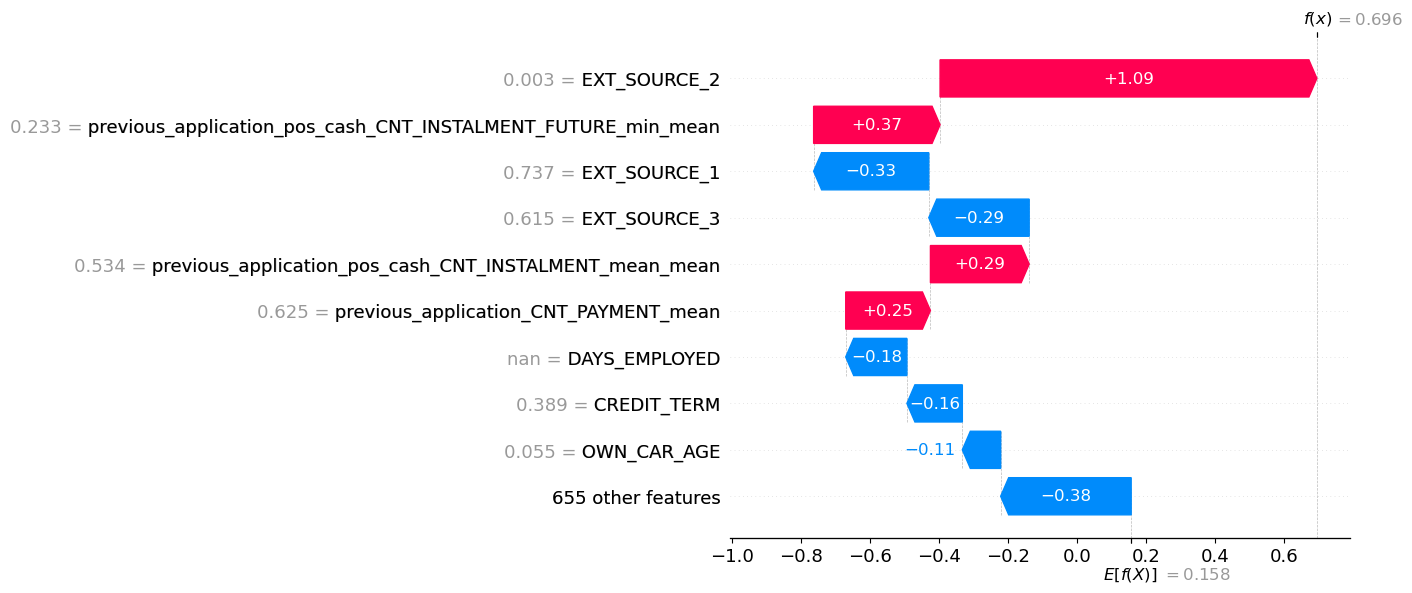

In [50]:
tree_explainer = shap.TreeExplainer(lgbm, X_even)
shap_values = tree_explainer(X_val_only_scaled[:3])
shap_values.feature_names = features_names

shap.waterfall_plot(shap_values[0])

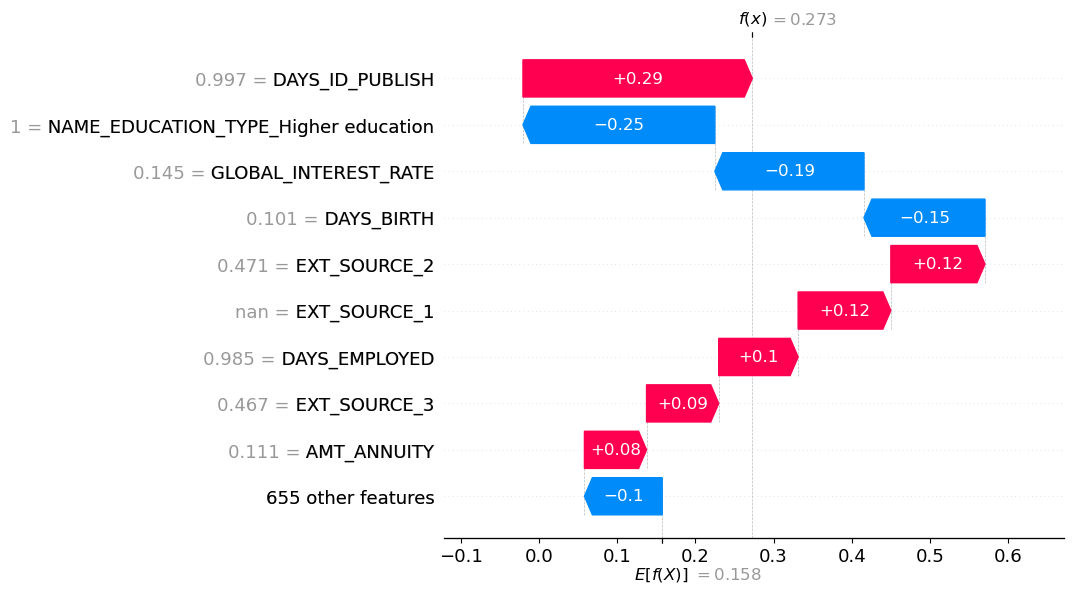

In [51]:
shap.waterfall_plot(shap_values[1])

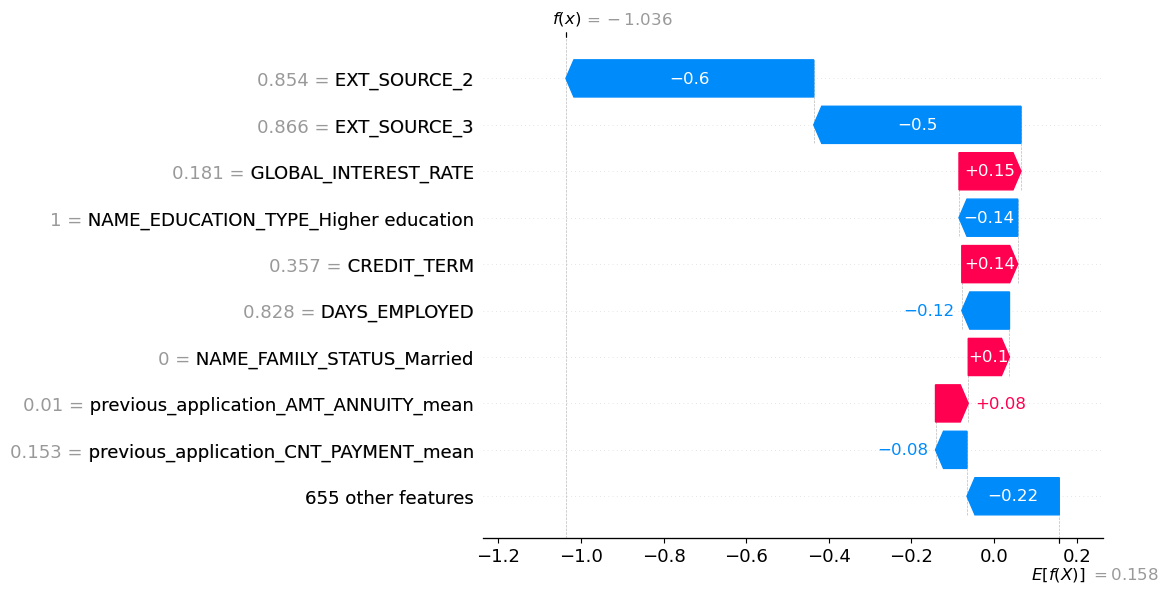

In [52]:
shap.waterfall_plot(shap_values[2])

# API, MLFLOW

In [5]:
#!mlflow ui

^C


In [52]:
result = mlflow.register_model(f"runs:/{run_id}/model", "CreditScoringModel")

Registered model 'CreditScoringModel' already exists. Creating a new version of this model...
2025/11/28 11:33:22 WARNING mlflow.tracking._model_registry.fluent: Run with id 118f33ea9be246a1a3721549c674b0a4 has no artifacts at artifact path 'model', registering model based on models:/m-f83c5cb712354c049e4d624115710f95 instead
Created version '1' of model 'CreditScoringModel'.


In [62]:
import requests

sample = X_val_only_scaled[0:1].copy()
sample = np.nan_to_num(sample, nan=0.0, posinf=0.0, neginf=0.0)
sample = sample.tolist()

data = {"inputs": sample}
response = requests.post("http://localhost:1234/invocations", json=data)
print(response.json())

{'predictions': [1]}


In [64]:
import json

with open("sample_input.json", "w") as f:
    json.dump({"inputs": sample}, f, indent=4)